# <span style='font-family:Serif'>**Stock Portfolio Financial Advisor**</span>

This program will analyze an individual's current stock holdings to **recommend** <u>**similar**</u> **stocks** from the S&P500 \(a common stock market index\) for the investor to purchase.

I used a database of all 504 S&P500 stocks as of 2021. The database includes information such as stock ticker \(e.g. MSFT, KO, AAPL\), price\-to\-earnings ratio, stock sector \(i.e. Information Tech, Financials, Health Care\), market cap, stock price, and more. You can access the database here: [https://www.kaggle.com/datasets/paytonfisher/sp\-500\-companies\-with\-financial\-information?resource=download](https://www.kaggle.com/datasets/paytonfisher/sp-500-companies-with-financial-information?resource=download) 



## Import necessary libraries



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import math
import seaborn as sns

fileAddress = "Documents/datasets/financials.csv"

dataset = pd.read_csv(fileAddress)

datacopy = pd.read_csv(fileAddress)

## Define your portfolio

I used an example of some popular S&P500 stocks. The number on the right corresponds to how much of that stock \(in dollars \$\) I hypothetically own. Stocks that comprise a bigger proportion of your portfolio will be weighted higher in the future.


In [3]:
myPortfolio = [
    ["AAPL",400],
    ["INTU",300],
    ["NVDA",200],
    ["MSFT",200],
    ["WMT",150],
    ["NKE",100],
    ["PG",175],
    ["PCG",100],
    ["USB",100],
]

## Clean and Prepare our data

Since this dataset is in the numpy/pandas system, it is difficult to index a specific stock, so I will set up some functions to do that for me. I have also added some boolean data columns \("isTech", etc.\) to represent the hard\-to\-quantify "Sector" variable.

All string numbers are replaced with floats, and all blank values are filled with a zero \(0\).


In [4]:
portfolioSize = 0
for i in myPortfolio:
    portfolioSize += i[1]
    
def getShare(ticker):
    for i in myPortfolio:
        if i[0]==ticker:
            return i[1]

myTickers = [d[0] for d in myPortfolio]

# Create boolean sector variables...
dataset['isTech'] = [((d=="Information Technology" or d=="Telecommunication Services") and 1) or -1 for d in datacopy["Sector"]]
dataset['isUtility'] = [((d=="Utilities" or d=="Energy") and 1) or -1 for d in datacopy["Sector"]]
dataset['isConsumer'] = [((d=="Consumer Staples" or d=="Consumer Discretionary") and 1) or -1 for d in datacopy["Sector"]]
dataset['isIndustry'] = [((d=="Industrials" or d=="Materials") and 1) or -1 for d in datacopy["Sector"]]
dataset['isMoney'] = [((d=="Financials" or d=="Real Estate") and 1) or -1 for d in datacopy["Sector"]]
dataset['isHealth'] = [(d=="Health Care" and 1) or -1 for d in datacopy["Sector"]]

# Decide which values we want to look at later on...
interestArray = ['Symbol','Price','Price/Earnings','Dividend Yield','Earnings/Share','Market Cap','isTech','isUtility','isConsumer','isIndustry','isMoney','isHealth']

# Clean the data a bit...
dataset.fillna(0,inplace=True)
for i in interestArray:
    if i != "Symbol":
        dataset.astype({i:'float'})

dataset = dataset[interestArray]
dataset

,Symbol,Price,Price/Earnings,Dividend Yield,Earnings/Share,Market Cap,isTech,isUtility,isConsumer,isIndustry,isMoney,isHealth
0,MMM,222.89,24.31,2.332862,7.92,1.387211e+11,-1,-1,-1,1,-1,-1
1,AOS,60.24,27.76,1.147959,1.70,1.078342e+10,-1,-1,-1,1,-1,-1
2,ABT,56.27,22.51,1.908982,0.26,1.021210e+11,-1,-1,-1,-1,-1,1
3,ABBV,108.48,19.41,2.499560,3.29,1.813863e+11,-1,-1,-1,-1,-1,1
4,ACN,150.51,25.47,1.714470,5.44,9.876586e+10,1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,70.24,30.94,1.170079,1.83,1.291502e+10,-1,-1,-1,1,-1,-1
501,YUM,76.30,27.25,1.797080,4.07,2.700330e+10,-1,-1,1,-1,-1,-1
502,ZBH,115.53,14.32,0.794834,9.01,2.445470e+10,-1,-1,-1,-1,-1,1
503,ZION,50.71,17.73,1.480933,2.60,1.067068e+10,-1,-1,-1,-1,1,-1


## Some more functions to help us index individual stocks later.



In [5]:
def findStock(ticker):
    tab = {}
    i=0
    for d in dataset['Symbol']:
        if d == ticker:
            for attribute in interestArray:
                tab[attribute] = (dataset[attribute][i])
        i+=1
    return tab

def getName(ticker):
    i=0
    for d in datacopy['Symbol']:
        if d == ticker:
            return datacopy['Name'][i]
        i+=1

#Find mean value of each numerical statistic
means = {}
for term in interestArray:
    if term != "Symbol":
        asum = 0
        for i in dataset["Symbol"]:
            asum += findStock(i)[term]
        means[term] = asum / len(dataset["Symbol"])

def getCore(stockDict):
    return [stockDict[i]/means[i] for i in stockDict if not i == "Symbol"]

## <u>A cosine function to compare our portfolio's stocks to each S&P500 stock.</u>



In [6]:
def cosine(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

## Make some recommendations!

### Use a weighted cosine function and the Pythagorean Theorem.

We compare each attribute of each portfolio stock to each attribute of each S&P500 stock, and then use a form of weighted averaging to find a general consensus of how well a given S&P500 stock matches our portfolio as a whole.


In [7]:
recommendations = []

for symbol in dataset["Symbol"]:
    if not symbol in myTickers:
        thisStock = findStock(symbol)
        thisCore = getCore(thisStock)
        cosines = []
        for ticker in myTickers:
            #print(ticker)
            myStock = findStock(ticker)
            myCore = getCore(myStock)
            #print(myStock)
            cos = cosine(thisCore,myCore)
            cosines.append([ticker,cos])
        pythagorasSum = 0
        for cos in cosines:
            pythagorasSum += (cos[1]**2) * getShare(cos[0])
        pythagorasCos = math.sqrt(pythagorasSum / portfolioSize)
        finalValue = pythagorasCos#/len(cosines)
        recommendations.append([finalValue,symbol,getName(symbol)])
    
#recommendations
def orderFn(e):
    return e[0]
    
recommendations.sort(reverse=True,key=orderFn)

#Purify/round data
def clean(rec):
    formatstring = ""
    if rec[0]>0.5:
        formatString = str.ljust("\033[95m\033[1m%s (%s)\033[0m",50-len(rec[2])," ") + " with a weighted pythagorean cosine similarity of    \033[92m\033[1m%s\033[0m"
    else:
        formatString = str.ljust("\033[95m\033[1m%s (%s)\033[0m",50-len(rec[2])," ") + " with a weighted pythagorean cosine similarity of    \033[91m\033[1m%s\033[0m"
        
    return formatString % (rec[2],rec[1],str(rec[0])[:5])

def clarifyTop(count):
    print("Based on your investment preferences, I recommend the following %i stocks:\n"%count)
    for i in range(count):
        print(clean(recommendations[i]))
    print("\nBased on your investment preferences, I DO NOT recommend the following %i stocks:\n"%count)
    for i in range(len(recommendations)-count,len(recommendations)):
        print(clean(recommendations[i]))

## Call the function outlined above to provide a list of the 10 _best_ matches and the 10 _worst_ matches.

In this example, the top 3 stocks are Visa, Facebook, and Mastercard, while the bottom 3 are Perrigo, CF Industries, and Hess Corporation. This makes a lot of sense, because my portfolio is heavy on technology companies but has no utility or health care stocks.

Some stocks matched my portfolio by as much as 78.5%, while others match by as little as 6.9%.


In [8]:
clarifyTop(10) # Get our top and bottom N results!

Based on your investment preferences, I recommend the following 10 stocks:

Visa Inc. (V)                      with a weighted pythagorean cosine similarity of    0.790
Facebook, Inc. (FB)                 with a weighted pythagorean cosine similarity of    0.779
Mastercard Inc. (MA)                with a weighted pythagorean cosine similarity of    0.775
Oracle Corp. (ORCL)                   with a weighted pythagorean cosine similarity of    0.767
Intel Corp. (INTC)                    with a weighted pythagorean cosine similarity of    0.759
Cisco Systems (CSCO)                  with a weighted pythagorean cosine similarity of    0.756
Verizon Communications (VZ)         with a weighted pythagorean cosine similarity of    0.738
AT&T Inc (T)                       with a weighted pythagorean cosine similarity of    0.734
Home Depot (HD)                     with a weighted pythagorean cosine similarity of    0.726
Exxon Mobil Corp. (XOM)              with a weighted pythagorean cosine si

## Finally, draw a beautiful graph to demonstrate the distributions of our data!

### This graph shows the distribution of overall similarity scores for each S&P500 stock compared to my portfolio.

A few observations & summary statistics:

- The distribution appears _roughly_ unimodal and symmetrical
- The data is centered around 0.42
- The data has a standard deviation of around 0.127



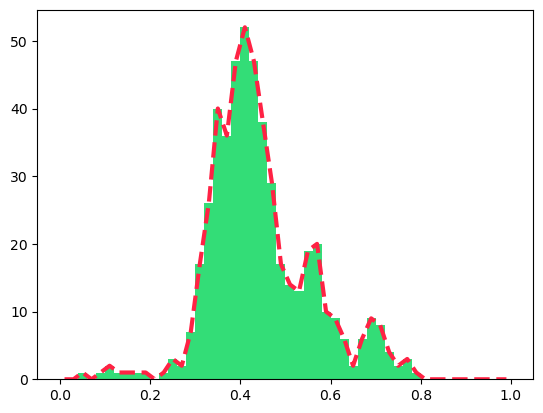

Mean Similarity: 0.444601
Median Similarity: 0.425665
Standard Deviation: 0.114118


In [9]:
bins = []
binCount = 50
for i in range(binCount+1):
    bins.append(i/binCount)
rawRecs = [d[0] for d in recommendations]

myHist = plt.hist(rawRecs,bins,color='#33dd77')

y,binEdges = np.histogram(rawRecs,bins=50,range=[0,1])
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])

myScatter = plt.plot(binCenters,y,'--',alpha=1,color="#ff2244",linewidth=3)
plt.show()

print("Mean Similarity: %f" % (sum(rawRecs)/len(rawRecs)))
print("Median Similarity: %f" % (rawRecs[math.floor((len(rawRecs)/2))]))
print("Standard Deviation: %f" % (np.std(rawRecs)))

# <span style='font-family:Serif'>**A very promising conclusion**</span>

### This program proves that many aspects of finances and economics can be accurately predicted and ascribed using data models.

### In the future, this program could be used to help individuals diversify their stock portfolios. By looking at the highest matches, investors can purchase stocks within their chosen sectors to avoid putting all their eggs in one basket, so to speak. They can also look at the lowest numbers to see which stock categories are most underrepresented in their portfolios, in order to increase sector diversity, among other factors.

### For example, health care stocks ranked lowest for me because my hypothetical portfolio did not contain any health care stocks. This program highlighted a lack of diversity in my portfolio and effectively gave suggestions of how to improve it.

